In [1]:
"""
Run exploration with high resolution within the connection strengths (100x100), but with only two different values for
the frequencies of the fast and slow oscillators.

"""

import numpy as np
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.models.multimodel import MultiModel
from hopf_cfc_network import SlowFastHopfNetwork
from cfcUtils import modulation_index
from scipy.signal import find_peaks
import neurolib.utils.pypetUtils as pu
import neurolib.optimize.exploration.explorationUtils as eu
import matplotlib.pyplot as plt
import h5py

# w instrinsic
# 0.003 ~ 0.5Hz
# 0.005 ~ 0.8Hz
# 0.01 ~ 2Hz
# 0.05 ~ 8Hz
# 0.06 ~ 10Hz
# 0.08 ~ 12Hz
# 0.1 ~ 17Hz
# 0.2 ~ 32Hz
# 0.3 ~ 50Hz

In [2]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms

model = MultiModel(
    SlowFastHopfNetwork(
        number_of_slow_fast_units=1,
        slow_to_fast_connection=0.0,
        fast_to_slow_connection=0.0,
    )
)

model.params["duration"] = DURATION
model.params["sampling_dt"] = DT
model.params["dt"] = 0.01  # ms - lower dt for numba backend
# numba backend is the way to go in exploration - much faster
model.params["backend"] = "numba"

# manually add params you want to change during exploration, btw model.params is just a dictionary, so you can add whatever :)
model.params["slow_to_fast"] = 0.0
model.params["fast_to_slow"] = 0.0
model.params["frequency_slow"] = 0.04
model.params["frequency_fast"] = 0.2


In [3]:
parameters = ParameterSpace(
    {
        "slow_to_fast": np.append(np.linspace(0.0, 1., 50), np.linspace(1., 10., 50)),
        "fast_to_slow": np.append(np.linspace(0.0, 1., 50), np.linspace(1., 10., 50)),
        "frequency_slow": np.array([0.025,0.04]),
        "frequency_fast": np.array([0.14,0.2])
    },
    allow_star_notation=True,
    kind="grid",
)

# Default params:
# slow_frequency: 0.04
# fast_frequency: 0.2


In [4]:
def evaluateSimulation(traj):
    # get model with parameters for this run
    model = search.getModelFromTraj(traj)
    # extract stuff you want
    s_f_conn = model.params["slow_to_fast"]
    f_s_conn = model.params["fast_to_slow"]

    model.params["*connectivity"] = np.array([[0.0, f_s_conn], [s_f_conn, 0.0]])
    model.params['SlowFastHopfNet.SlowHopf_0.HopfMass_0.w'] = model.params["frequency_slow"]
    model.params['SlowFastHopfNet.FastHopf_1.HopfMass_0.w'] = model.params["frequency_fast"]

    model.run()

    n_bins = 18

    phase_slow = np.arctan2(model.y[0, :], model.x[0, :])
    amp_fast = np.sqrt(model.x[1, :] ** 2 + model.y[1, :] ** 2)
    binned_phase = np.digitize(phase_slow, bins=np.linspace(-np.pi, np.pi, n_bins + 1))
    mean_bin_amp = np.zeros(n_bins + 1)  # in theory index of bins goes from 0 to N_BINS
    for bin_idx in np.unique(binned_phase):
        mean_bin_amp[bin_idx] = np.mean(amp_fast[binned_phase == bin_idx])

    mean_bin_amp = mean_bin_amp[
                   1:
                   ]  # because in theory there could be stuff that is smaller than -pi, then actually the interval between -pi and the next bin has index 1.
    # normalize the mean amplitude in each bin
    mean_bin_amp = mean_bin_amp / np.sum(mean_bin_amp)
    mi = modulation_index(mean_bin_amp)

    freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=40, spectrum_windowsize=1)
    freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=40, spectrum_windowsize=1)

    peaks_fast, _ = find_peaks(pow_fast, height=max(1e-3, 1.0 * np.std(pow_fast)))
    peaks_slow, _ = find_peaks(pow_slow, height=max(1e-3, 0.5 * np.std(pow_slow)))



    result_dict = {
        "modulation_index": mi,
        "peaks_freq_fast": peaks_fast,
        "peaks_freq_slow": peaks_slow
    }

    search.saveToPypet(result_dict, traj)


In [5]:
search = BoxSearch(
    model=model,
    evalFunction=evaluateSimulation,
    parameterSpace=parameters,
    filename="high_resolution_exploration.hdf",
    ncores=50,
)


MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/high_resolution_exploration.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 40000
MainProcess root INFO     BoxSearch: Environment initialized.


In [6]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/high_resolution_exploration.hdf
MainProcess root INFO     Analyzing trajectory results-2022-05-09-15H-55M-16S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/high_resolution_exploration.hdf`.
MainProcess pypet.storageservice.HDF5StorageService WARNING  Current pypet version is 0.6.0 with python 3.8.10 but your trajectory was created with version 0.6.0 under python 3.9.7. Yet, you enforced the load, so I will handle the trajectory despite the version mismatch.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-05-09-15H-55M-16S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess pyp

In [7]:
search.dfResults

,slow_to_fast,fast_to_slow,frequency_slow,frequency_fast,peaks_freq_slow,peaks_freq_fast,modulation_index
0,0.0,0.000000,0.025,0.14,[4],[22],8.174769e-11
1,0.0,0.000000,0.025,0.20,[4],[32],8.233584e-11
2,0.0,0.000000,0.040,0.14,[6],[22],7.246143e-11
3,0.0,0.000000,0.040,0.20,[6],[32],7.298996e-11
4,0.0,0.020408,0.025,0.14,[4],[22],8.023307e-11
...,...,...,...,...,...,...,...
39995,10.0,9.816327,0.040,0.20,"[11, 20, 27, 33, 37]","[7, 12]",8.394550e-01
39996,10.0,10.000000,0.025,0.14,[],[],2.967645e-01
39997,10.0,10.000000,0.025,0.20,[1],[],2.000822e-01
39998,10.0,10.000000,0.040,0.14,[],[],1.895558e-01


In [8]:
search.dfResults['max_freq_slow'] = search.dfResults.apply(
    lambda row: np.amax(row["peaks_freq_slow"],initial=0), axis=1
    )
search.dfResults['max_freq_fast'] = search.dfResults.apply(
    lambda row: np.amax(row["peaks_freq_fast"], initial=0), axis=1
    )
search.dfResults["ratio_freq"]=search.dfResults.apply(
    lambda row: row["frequency_fast"]/row["frequency_slow"],axis=1)

In [9]:
search.dfResults

,slow_to_fast,fast_to_slow,frequency_slow,frequency_fast,peaks_freq_slow,peaks_freq_fast,modulation_index,max_freq_slow,max_freq_fast,ratio_freq
0,0.0,0.000000,0.025,0.14,[4],[22],8.174769e-11,4,22,5.6
1,0.0,0.000000,0.025,0.20,[4],[32],8.233584e-11,4,32,8.0
2,0.0,0.000000,0.040,0.14,[6],[22],7.246143e-11,6,22,3.5
3,0.0,0.000000,0.040,0.20,[6],[32],7.298996e-11,6,32,5.0
4,0.0,0.020408,0.025,0.14,[4],[22],8.023307e-11,4,22,5.6
...,...,...,...,...,...,...,...,...,...,...
39995,10.0,9.816327,0.040,0.20,"[11, 20, 27, 33, 37]","[7, 12]",8.394550e-01,37,12,5.0
39996,10.0,10.000000,0.025,0.14,[],[],2.967645e-01,0,0,5.6
39997,10.0,10.000000,0.025,0.20,[1],[],2.000822e-01,1,0,8.0
39998,10.0,10.000000,0.040,0.14,[],[],1.895558e-01,0,0,3.5


In [10]:
# "frequency_slow": np.array([0.025,0.04]),
# "frequency_fast": np.array([0.14,0.2])

/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, z

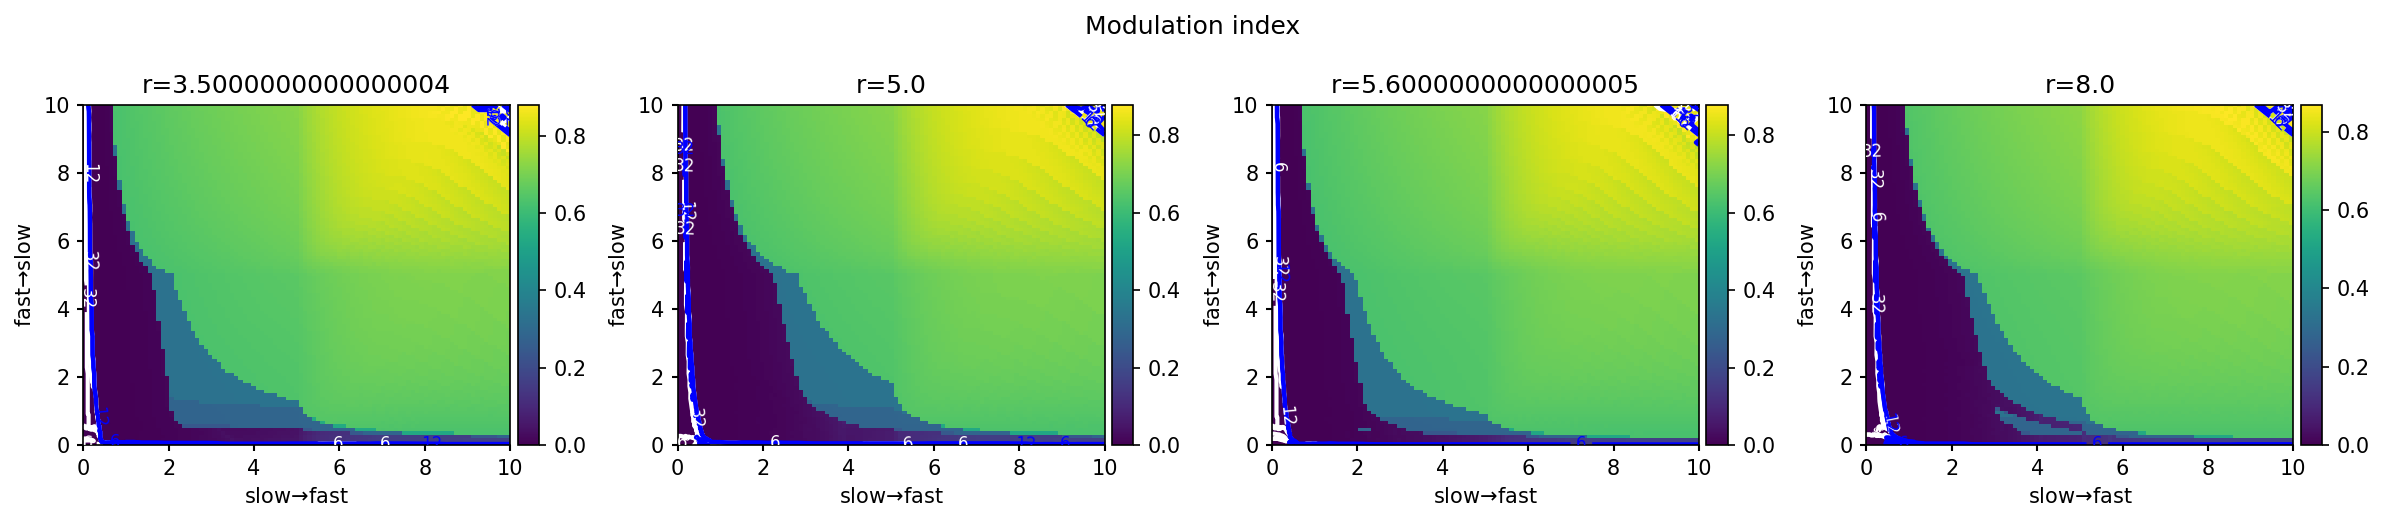

In [11]:
eu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow$\to$fast"],
    par2=["fast_to_slow", r"fast$\to$slow"],
    plot_key="modulation_index",
    nan_to_zero=False,
    by= "ratio_freq",
    one_figure= True,
    plot_key_label="Modulation index",
    contour=["max_freq_slow", "max_freq_fast"],
    contour_color=[["white"], ["blue"]],
    contour_levels=[[6,12,32], [6,12,32]],
    contour_alpha=[1.0, 1.0],
    contour_kwargs={
        0: {"linewidths": (2,), "clabel": True},
        1: {"linewidths": (2,), "clabel": True},
    },
    # savename="diff_ratios_full_high_res_exploration"
)

/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, z

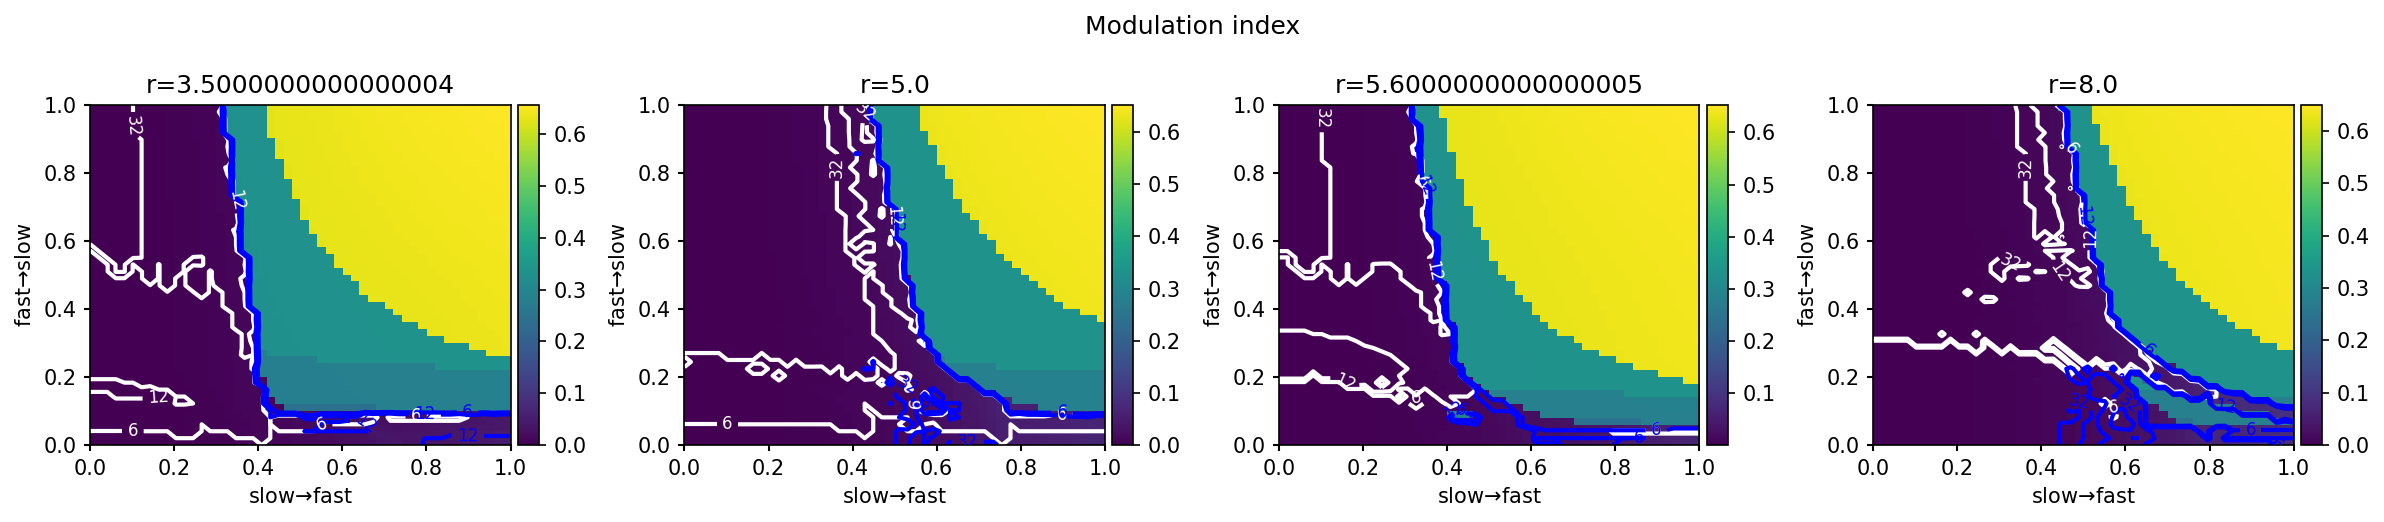

In [12]:
eu.plotExplorationResults(
    search.dfResults[(search.dfResults["slow_to_fast"]<=1) & (search.dfResults["fast_to_slow"]<=1)],
    par1=["slow_to_fast", r"slow$\to$fast"],
    par2=["fast_to_slow", r"fast$\to$slow"],
    plot_key="modulation_index",
    nan_to_zero=False,
    by = "ratio_freq",
    one_figure= True,
    plot_key_label="Modulation index",
    contour=["max_freq_slow", "max_freq_fast"],
    contour_color=[["white"], ["blue"]],
    contour_levels=[[6,12,32], [6,12,32]],
    contour_alpha=[1.0, 1.0],
    contour_kwargs={
        0: {"linewidths": (2,), "clabel": True},
        1: {"linewidths": (2,), "clabel": True},
    },
)

/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, z

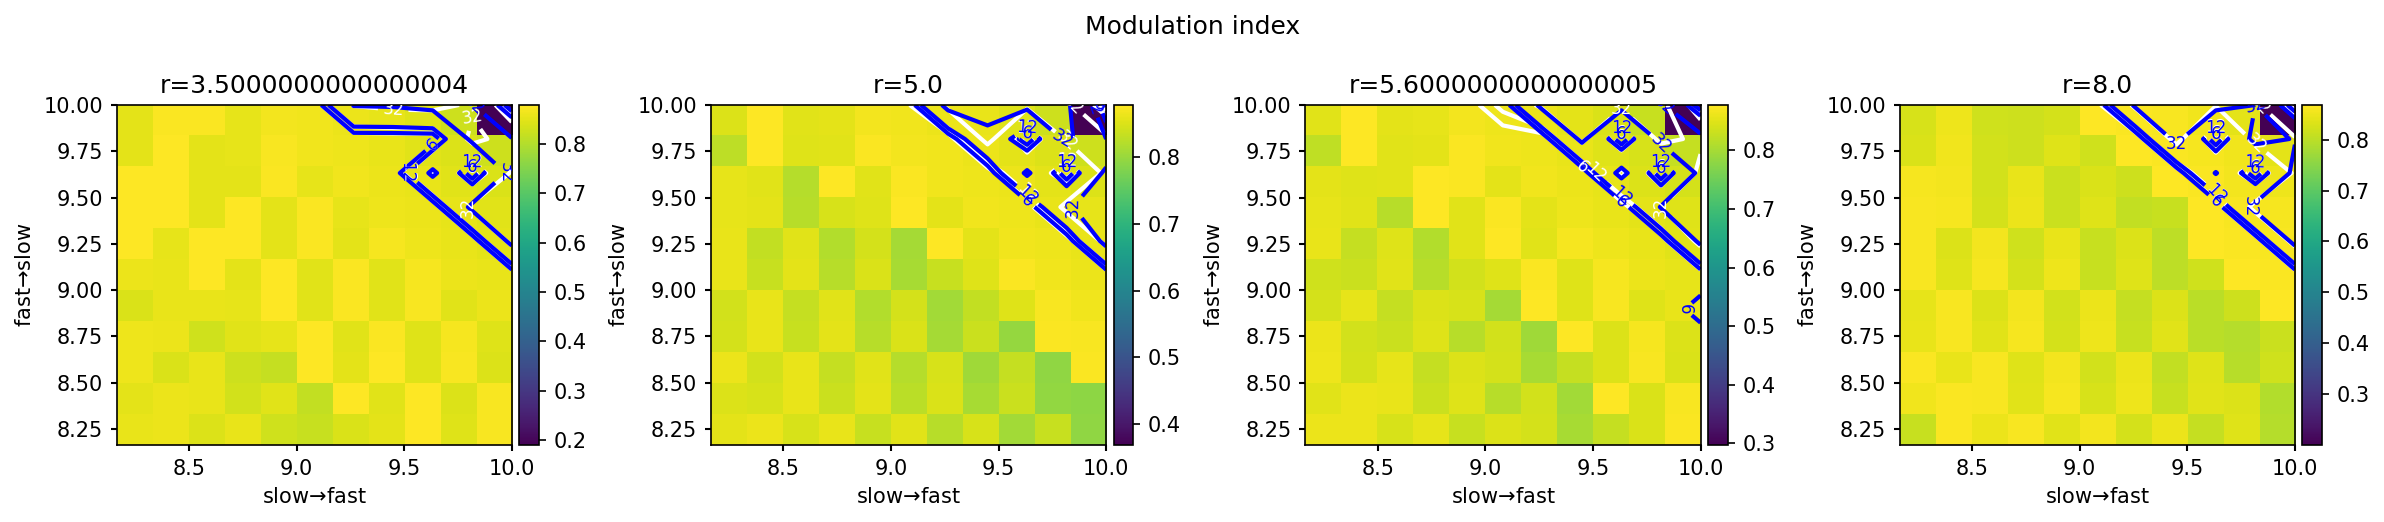

In [13]:
eu.plotExplorationResults(
    search.dfResults[(search.dfResults["slow_to_fast"]>8) & (search.dfResults["fast_to_slow"]>8)],
    par1=["slow_to_fast", r"slow$\to$fast"],
    par2=["fast_to_slow", r"fast$\to$slow"],
    plot_key="modulation_index",
    nan_to_zero=False,
    by = "ratio_freq",
    one_figure= True,
    plot_key_label="Modulation index",
    contour=["max_freq_slow", "max_freq_fast"],
    contour_color=[["white"], ["blue"]],
    contour_levels=[[6,12,32], [6,12,32]],
    contour_alpha=[1.0, 1.0],
    contour_kwargs={
        0: {"linewidths": (2,), "clabel": True},
        1: {"linewidths": (2,), "clabel": True},
    },
)

/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, z

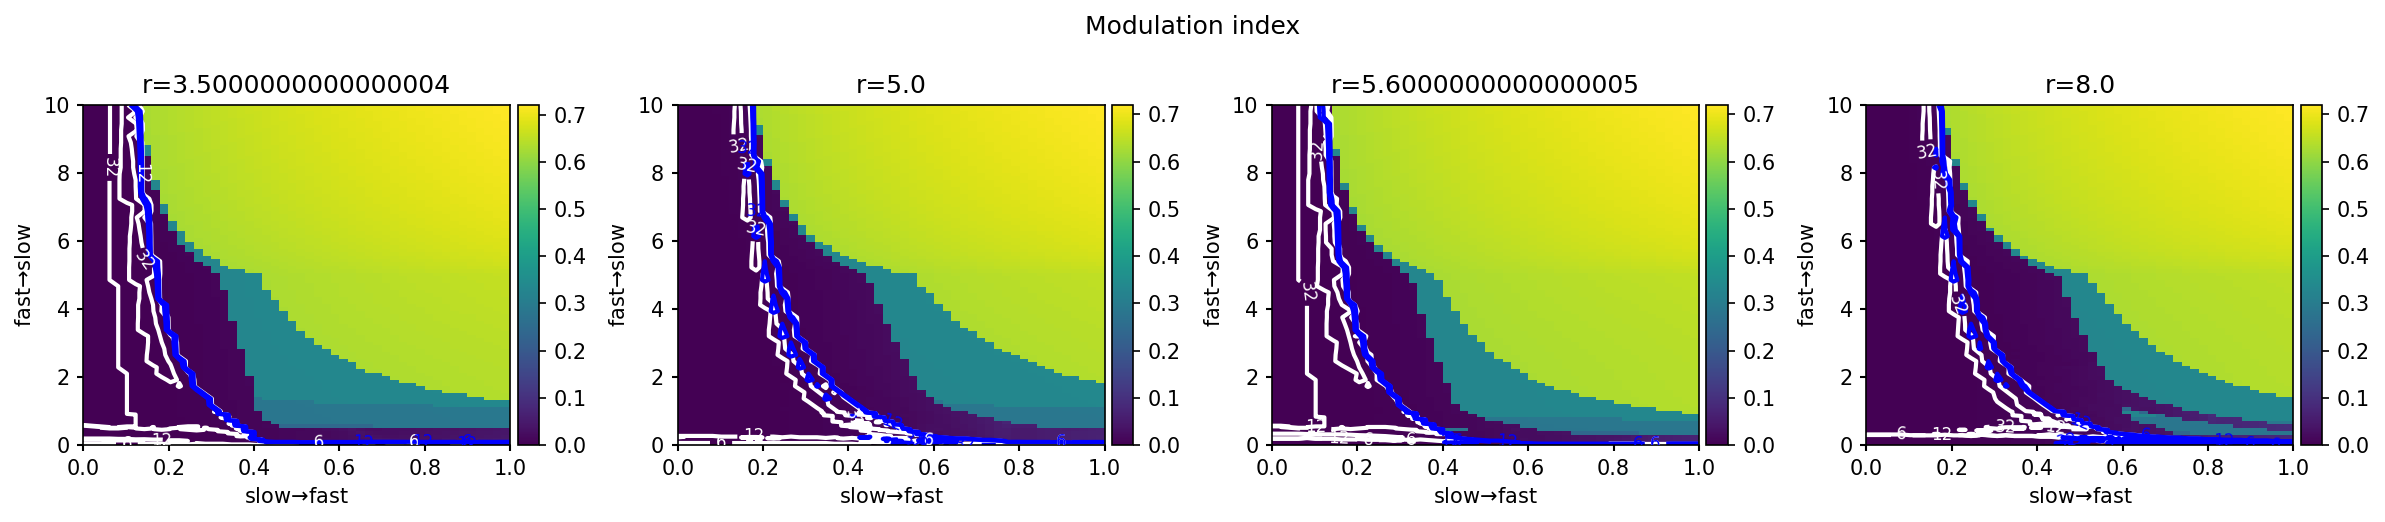

In [14]:
eu.plotExplorationResults(
    search.dfResults[(search.dfResults["slow_to_fast"]<=1)],
    par1=["slow_to_fast", r"slow$\to$fast"],
    par2=["fast_to_slow", r"fast$\to$slow"],
    plot_key="modulation_index",
    nan_to_zero=False,
    by = "ratio_freq",
    one_figure= True,
    plot_key_label="Modulation index",
    contour=["max_freq_slow", "max_freq_fast"],
    contour_color=[["white"], ["blue"]],
    contour_levels=[[6,12,32], [6,12,32]],
    contour_alpha=[1.0, 1.0],
    contour_kwargs={
        0: {"linewidths": (2,), "clabel": True},
        1: {"linewidths": (2,), "clabel": True},
    },
)

/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, zorder=1, alpha=alpha, **contour_kwargs,)
/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/neurolib/optimize/exploration/explorationUtils.py:246: UserWarning: The following kwargs were not used by contour: 'clabel'
  contours = ax.contour(Xi, Yi, dataframe, colors=color, levels=levels, z

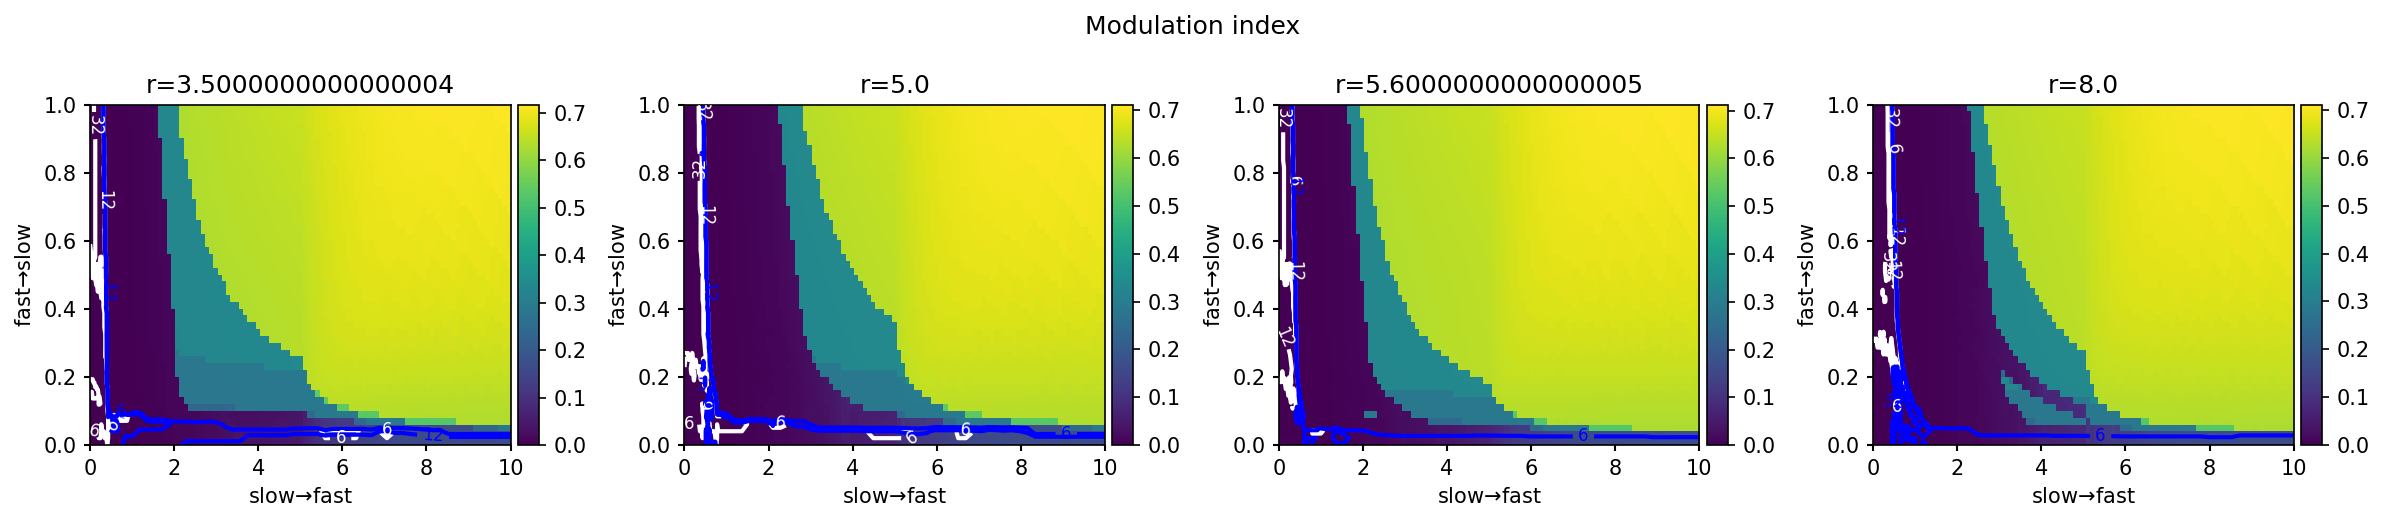

In [15]:
eu.plotExplorationResults(
    search.dfResults[(search.dfResults["fast_to_slow"]<=1)],
    par1=["slow_to_fast", r"slow$\to$fast"],
    par2=["fast_to_slow", r"fast$\to$slow"],
    plot_key="modulation_index",
    nan_to_zero=False,
    by = "ratio_freq",
    one_figure= True,
    plot_key_label="Modulation index",
    contour=["max_freq_slow", "max_freq_fast"],
    contour_color=[["white"], ["blue"]],
    contour_levels=[[6,12,32], [6,12,32]],
    contour_alpha=[1.0, 1.0],
    contour_kwargs={
        0: {"linewidths": (2,), "clabel": True},
        1: {"linewidths": (2,), "clabel": True},
    },
)

In [16]:
search.dfResults.groupby(by = "ratio_freq")

In [16]:
# temp_var = []
# for ratio_freq_fs in np.unique(df_non_zero_conn.ratio_freq):
#     df_temp = df_non_zero_conn[df_non_zero_conn.ratio_freq == ratio_freq_fs]
#     sort_ratio_conn_fs, sort_MI_ratio_conn_fs = zip(*sorted(zip(df_temp.ratio_conn_fs, df_temp.modulation_index)))
#
#     sort_ratio_conn_sf, sort_MI_ratio_conn_sf = zip(
#         *sorted(zip(df_temp.ratio_conn_sf, df_temp.modulation_index)))
#
#     _, axs = plt.subplots(nrows=1, ncols=2, sharex="col", figsize=(20, 10))
# 
#     print(np.all(temp_var==sort_ratio_conn_sf))
#
#     axs[0].plot(sort_ratio_conn_fs,sort_MI_ratio_conn_fs)
#     axs[0].set_ylabel("Modulation Index")
#     axs[0].set_xlabel("fast_to_slow/slow_to_fast")
#     #axs[0].set_xlim(0,10)
#
#     axs[1].plot(sort_ratio_conn_sf, sort_MI_ratio_conn_sf)
#     axs[1].set_xlabel("slow_to_fast/fast_to_slow")
#     axs[1].set_ylabel("Modulation Index")
#     plt.suptitle(f"Frequency fast/ frequency slow = {ratio_freq_fs}")
#     #axs[1].set_xlim(0,10)
#     plt.show()
#
#     temp_var = sort_ratio_conn_sf
